In [31]:
# Import the necessary libraries
import numpy.linalg as lin
import scipy.integrate as intgr
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import requests
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special as spc
import os
# os.getcwd()

In [32]:
hh_inc = np.loadtxt('data/hh_inc_synth.txt')


# 1a)

In [33]:
#Create the first 40 bins. Only go to $200k because the ranges on these bins are equivalent
hist_first_40, bin_edges_first_40 = np.histogram(hh_inc, bins=40, range=(0, 200000)) #jose different
# print(max(hh_inc))
# num_bins = 41
# bin_width = 350000 / num_bins #based on fact that max value is approx. $350k
# weights_800 = ((1 / (hh_inc.shape[0] * bin_width))* np.ones_like(hh_inc)) #hsould they all have same weights?

#Create last two bins
hist_last_2, bin_edges_last_2 = np.histogram(hh_inc, bins=(200000, 250000, 350000), range=(200000, 350000))


#Join bins
hist_1b = np.append(hist_first_40, hist_last_2)
bin_edges_1b = np.append(bin_edges_first_40, bin_edges_last_2)

# 1b)

In [34]:
hh_inc_1b = hh_inc/1000

In [35]:
# hist_first_40, bin_edges_first_40 = np.histogram(hh_inc, bins=40, range=(0, 194.999)) #jose different
# hist_last_2, bin_edges_last_2 = np.histogram(hh_inc, bins=(200, 250, 350), range=(200, 350))

#Join bins
#hist_dt = np.append(hist_first_40, hist_last_2) #42 values
bin_edges_1b = np.append(bin_edges_first_40, bin_edges_last_2) #44 values
bin_edges_1b = bin_edges_1b/1000

In [36]:
from collections import Counter

weights = [0]*len(hh_inc_1b)
for w in range(0,len(weights)):
    #now write so it gets corresponding widths
        if hh_inc_1b[w] <= 199.999:
            weights[w] = 1/(len(hh_inc_1b) * 5)
        if hh_inc_1b[w] <= 249.999 and hh_inc_1b[w] >= 200 :
            weights[w] = 1/(len(hh_inc_1b) * 50)
        if hh_inc_1b[w] >= 250:
            weights[w] = 1/(len(hh_inc_1b) * 100)
            
#check that weights calculated correctly by identifying 3 unique weights
Counter(weights).keys() # equals to list(set(words))


dict_keys([1.651732254201594e-06, 8.258661271007969e-08, 1.6517322542015938e-07])

Text(0, 0.5, 'Density (area sums to 1)')

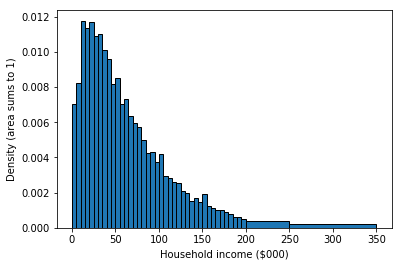

In [37]:
hist_vals= plt.hist(hh_inc_1b, bin_edges_1b, weights = weights, edgecolor = 'black')
plt.xlabel('Household income ($000)')
plt.ylabel('Density (area sums to 1)')


# 1c)

In [38]:
def ln_norm_pdf(xvals, mu, sigma):
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))
    return pdf_vals

In [39]:
def data_moments2(xvals, n, bin_edges):
    counts, bins = np.histogram(xvals, bins=bin_edges)
    data_moments = counts / n
    return data_moments

In [40]:
def model_moments2(mu, sigma, n, bin_edges):
    x = np.linspace(min(bin_edges), max(bin_edges), max(bin_edges)+1)
    pdf_vals = ln_norm_pdf(x[1:], mu, sigma)
    #create model moments by summing up number of instances in which each
    #pdf_val falls into each bin
    model_moments = []
    for i in range(len(bin_edges)-1):
        val_in_bin = pdf_vals[bin_edges[i] : bin_edges[i+1]]
        model_moments.append(np.sum(val_in_bin))
    model_moments = np.array(model_moments)
    return model_moments

In [41]:
def err_vec2(xvals, n, bin_edges, mu, sigma, simple):
    moments_data = data_moments2(xvals, n, bin_edges)
    moments_model = model_moments2(mu, sigma, n, bin_edges)

    if simple:
        err_vec = moments_model - moments_data
    else:
        err_vec = (moments_model - moments_data) / moments_data
    
    return err_vec

In [42]:
def criterion2(params, *args):
    mu, sigma = params
    xvals, W, n, bin_edges = args
    err = err_vec2(xvals, n, bin_edges, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [45]:
#trying to do it with values divided by 1000
# Initial guess
mu_init = np.mean(np.log(hh_inc_1b))
sigma_init = np.std(np.log(hh_inc_1b))
params_init = (mu_init, sigma_init)

#Get bins
bin_edges_adj = [i for i in range(0, 200+1, 5)] + [250, 350]

#Replace diagonals of identity matrix with data moments, to define W_hat
W_hat = np.eye(42) 
row,col = np.diag_indices(W_hat.shape[0])
W_hat[row,col] =  data_moments2(hh_inc_1b, len(hh_inc), bin_edges_adj)

gmm_args = (hh_inc_1b, W_hat, len(hh_inc), bin_edges_adj)

# Run optimization
results = opt.minimize(criterion2, params_init, args=(gmm_args))
mu_GMM1, sigma_GMM1 = results.x


# Get results
print('Initial guesses: ','mu_init=', mu_init, ' sigma_init=', sigma_init)
print('GMM output:', 'mu_GMM1=', mu_GMM1, ' sigma_GMM1=', sigma_GMM1)
print('Criterion function value', criterion2(results.x, *gmm_args))
print(results)

Initial guesses:  mu_init= 3.780552299347908  sigma_init= 1.0610439509283802
GMM output: mu_GMM1= 3.900899700438797  sigma_GMM1= 0.9674675494197709
Criterion function value 0.03223736484292869
      fun: 0.03223736484292869
 hess_inv: array([[ 0.53555493, -0.06215296],
       [-0.06215296,  0.54778911]])
      jac: array([9.77888703e-08, 1.60653144e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([3.9008997 , 0.96746755])


In [47]:
#redo this for another guess:
# Initial guess
mu_init = 4
sigma_init = 2
params_init = (mu_init, sigma_init)

# Run optimization
results = opt.minimize(criterion2, params_init, args=(gmm_args))
mu_GMM2, sigma_GMM2 = results.x


# Get results
print('Initial guesses: ','mu_init=', mu_init, ' sigma_init=', sigma_init)
print('GMM output:', 'mu_GMM2=', mu_GMM2, ' sigma_GMM2=', sigma_GMM2)
print('Criterion function value', criterion2(results.x, *gmm_args))
print('Note that this criterion function is slightly larger than above. This makes sense, as we are starting with a worse initial guess.')
print(results)


Initial guesses:  mu_init= 4  sigma_init= 2
GMM output: mu_GMM2= 3.9008996592801104  sigma_GMM2= 0.9674674773890501
Criterion function value 0.032237364842921536
Note that this criterion function is slightly larger than above. This makes sense, as we are starting with a worse initial guess.
      fun: 0.032237364842921536
 hess_inv: array([[ 0.5380762 , -0.05974712],
       [-0.05974712,  0.55800796]])
      jac: array([6.51925802e-09, 2.09547579e-08])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([3.90089966, 0.96746748])


In [15]:
#this is doing the optimization with values not divided by 1000
# # Initial guess
# mu_init = np.mean(np.log(hh_inc))
# sigma_init = np.std(np.log(hh_inc))
# params_init = (mu_init, sigma_init)

# #Get bins
# bin_edges = [i for i in range(0, 200000+1, 5000)] + [250000, 350000]

# #Replace diagonals of identity matrix with data moments, to define W_hat
# W_hat = np.eye(42) 
# row,col = np.diag_indices(W_hat.shape[0])
# W_hat[row,col] =  data_moments2(hh_inc, len(hh_inc), bin_edges)

# gmm_args = (hh_inc, W_hat, len(hh_inc), bin_edges)

# # Run optimization
# results = opt.minimize(criterion2, params_init, args=(gmm_args))
# mu_GMM1, sigma_GMM1 = results.x


# # Get results
# print('Initial guesses: ','mu_init=', mu_init, ' sigma_init=', sigma_init)
# print('GMM output:', 'mu_GMM1=', mu_GMM1, ' sigma_GMM1=', sigma_GMM1)
# print('Criterion function value', results.fun)
# print(results)

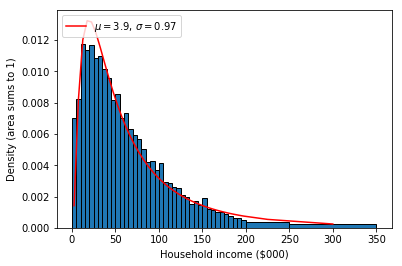

In [48]:
#plot histogram from 1b with implied histogram from first initial guess
bin_edges_adj = [i for i in range(0, 200+1, 5)] + [250, 350]
hist_vals= plt.hist(hh_inc_1b, bin_edges_adj, weights = weights, edgecolor = 'black')
plt.xlabel('Household income ($000)')
plt.ylabel('Density (area sums to 1)')

mid_pts = []
i = 0
for i in range(42):
    j = (bin_edges_adj[i+1]/2 - bin_edges_adj[i]/2 + bin_edges_adj[i])
    mid_pts.append(j)
    i+=1
    
mid_pts = np.asarray(mid_pts)
hist_values = ln_norm_pdf(mid_pts, mu_GMM1, sigma_GMM1)
plt.plot(mid_pts, hist_values,
         color = 'r', label = '$\mu = 3.9$, $\sigma = 0.97$')
plt.legend(loc='upper left')

# 1d) 

In [49]:
# Define function that generates values of GA pdf
import scipy.special as spc
def gamma_pdf(xvals, alpha, beta):
    gamma_val = spc.gamma(alpha)
    pdf_vals = (1/((beta**alpha) *gamma_val))*(xvals**(alpha-1))*(np.exp(-(xvals/beta)))
    pdf_vals[pdf_vals < 1e-10] = 1e-10 #added this
    return pdf_vals

In [50]:
def data_moments_1d(xvals, n, bin_edges):
    counts, bins = np.histogram(xvals, bins=bin_edges)
    data_moments = counts / n
    return data_moments

def model_moments_1d(alpha, beta, n, bin_edges):
    x = np.linspace(min(bin_edges), max(bin_edges), max(bin_edges)+1)
    pdf_vals = gamma_pdf(x[1:], alpha, beta)
    #create model moments by summing up number of instances in which each
    #pdf_val falls into each bin
    model_moments = []
    for i in range(len(bin_edges)-1):
        val_in_bin = pdf_vals[bin_edges[i] : bin_edges[i+1]]
        model_moments.append(np.sum(val_in_bin))
    model_moments = np.array(model_moments)
    return model_moments

In [51]:
#Define the error vector 
def err_vec_1d(xvals, n, bin_edges, alpha, beta, simple):
    data_moments = data_moments_1d(xvals, n, bin_edges)
    model_moments = model_moments_1d(alpha, beta, n, bin_edges)
    if simple: #simple difference
        err_vec = model_moments - data_moments
    else: #pct difference
        err_vec = (model_moments - data_moments) / data_moments
    
    return err_vec

In [52]:
#Define criterion function
def criterion_1d(params, *args):
    alpha, beta = params
    xvals, W, n, bin_edges = args
    err = err_vec_1d(xvals, n, bin_edges, alpha, beta, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [53]:
# Initial guess
alpha_init = 3
beta_init = 20000 #change this
params_init = (alpha_init, beta_init)

#Replace diagonals of identity matrix with data moments, to define W_hat
W_hat = np.eye(42) 
row,col = np.diag_indices(W_hat.shape[0])
W_hat[row,col] =  data_moments_1d(hh_inc_1b, len(hh_inc), bin_edges_adj)

gmm_args = (hh_inc_1b, W_hat, len(hh_inc), bin_edges_adj)

# Run optimization
results = opt.minimize(criterion_1d, params_init, args=(gmm_args), tol = 1e-12, method='L-BFGS-B')
alpha_GMM, beta_GMM = results.x

# Get results
print('Initial guesses: ','alpha_init=', alpha_init, 'beta_init=', beta_init)
print('GMM output:', 'alpha_GMM=', alpha_GMM, ' beta_GMM=', beta_GMM)
print('Criterion function value', criterion_1d(results.x, *gmm_args))
print(results)

/Users/erineidschun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/erineidschun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/Users/erineidschun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


Initial guesses:  alpha_init= 3 beta_init= 20000
GMM output: alpha_GMM= 0.3926102168315729  beta_GMM= 1587.7798390853495
Criterion function value 0.5169734441349287
      fun: 0.5169734441349287
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.82409643e-05, -1.11022302e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 327
      nit: 64
   status: 0
  success: True
        x: array([3.92610217e-01, 1.58777984e+03])


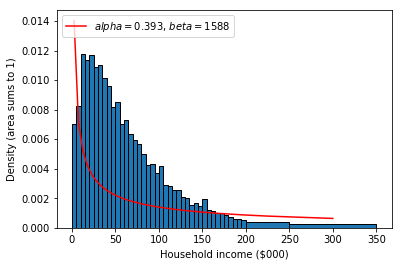

In [54]:
#plot histogram from 1b with implied histogram from first initial guess
bin_edges_adj = [i for i in range(0, 200+1, 5)] + [250, 350]
hist_vals= plt.hist(hh_inc_1b, bin_edges_adj, weights = weights, edgecolor = 'black')
plt.xlabel('Household income ($000)')
plt.ylabel('Density (area sums to 1)')

hist_values_GA = gamma_pdf(mid_pts, alpha_GMM, beta_GMM)
plt.plot(mid_pts, hist_values_GA,
         color = 'r', label = '$alpha = 0.393$, $beta = 1588$')
plt.legend(loc='upper left')

# 1e)

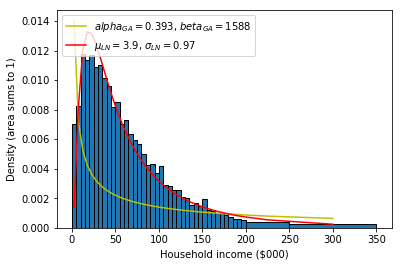

In [55]:
#plot histogram from 1b with implied histogram from first initial guess
bin_edges_adj = [i for i in range(0, 200+1, 5)] + [250, 350]
hist_vals= plt.hist(hh_inc_1b, bin_edges_adj, weights = weights, edgecolor = 'black')
plt.xlabel('Household income ($000)')
plt.ylabel('Density (area sums to 1)')

hist_values_GA = gamma_pdf(mid_pts, alpha_GMM, beta_GMM)
plt.plot(mid_pts, hist_values_GA,
         color = 'y', label = '$alpha_{GA} = 0.393$, $beta_{GA} = 1588$')
plt.legend(loc='upper left')

plt.plot(mid_pts, hist_values,
         color = 'r', label = '$\mu_{LN} = 3.9$, $\sigma_{LN} = 0.97$')
plt.legend(loc='upper left')

We can tell which distribution fits best by looking visually - it is quite obvious that the log normal distribution better fits the data, as it puts more weight on the values between 0 and 50, and less on the right tail of the data. Additionally, the criterion function for the lognormal distribution is much lower: 0.03551, verses the GA distribution, which has a criterion value of 0.516.

# 1f)

In [56]:
def get_err_mat(xvals, n, bin_edges, alpha, beta, simple=False):
    R = 42 #number of bins
    Err_mat = np.zeros((R, n))
    model_points = model_moments_1d(alpha, beta, n, bin_edges) #42 values
    data_points = data_moments_1d(xvals, n, bin_edges) #42 values
    if simple:
        for i in range(0, len(model_points)): #for i in range (0, 42)
            Err_mat[i, :] = data_points[i] - model_points[i]
    else:
        for i in range(0, len(model_points)): #for i in range (0, 42)
            Err_mat[i, :] = (data_points[i] - model_points[i])/model_points[i]
            
    return Err_mat

In [72]:
Err_mat = get_err_mat(hh_inc_1b, len(hh_inc), bin_edges_adj, alpha_GMM, beta_GMM, False)
VCV2 = (1 / len(hh_inc_1b)) * (Err_mat @ Err_mat.T)
W_hat2 = lin.inv(VCV2)

alpha_init = 3

beta_init = 20000 #change this
params_init = np.array([alpha_init, beta_init])
gmm_args = (hh_inc_1b, W_hat2, len(hh_inc_1b), bin_edges_adj)

results = opt.minimize(criterion_1d, params_init, args=(gmm_args), tol = 1e-18,
                       method = 'TNC', bounds=((1e-10, None), (1e-14, None)))#,
                      #options = {'ftol': 1e-14, 'eps':1e-14})
alpha_GMM_GA_1f, beta_GMM_GA_1f = results.x
print('alpha_GMM=', alpha_GMM_GA_1f, ' beta_GMM=', beta_GMM_GA_1f)

results


alpha_GMM= 5.1481807240182995  beta_GMM= 19980.662185585596


     fun: -1.6618339112473744e+16
     jac: array([0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 9
     nit: 2
  status: 0
 success: True
       x: array([5.14818072e+00, 1.99806622e+04])

In [30]:
#criterion function calue
criterion_1d(results.x, *gmm_args)

-1.6618339112473744e+16

The alpha and beta value are closer to 3 and 20,000, respectively, although I am unsure if my convergence was successful, so this could be why. 

For goodness of fit, we could compare the criterion function values. It appears the criterion value was much lower in 1d than 1f, so the distribution for 1d, with the weighting matrix weighed by moments, appears to be optimal. 

i'm assuming that my answer to 1f is not correct given the small amount of iterations, and so that the true answer would actually yield a lower criterion value and so be better than that in 1d . 

# 2

In [153]:
#load data
macroseries = np.loadtxt('Data/MacroSeries.txt', delimiter=',')
df = pd.DataFrame(macroseries)
df.columns = ['c', 'k', 'w', 'r']


In [154]:
#Define data moments
def calc_data_moments(xvals): #doesn't seem to need an argumentb but try for now
    
    m1_data = 0 #(6)
    m2_data = 0 #(7)
    m3_data = 0 #(8)
    m4_data = 0 #(9)
    
    data_moments = [m1_data, m2_data, m3_data, m4_data]
    return data_moments

def calc_model_moments(c, k, w, r, alpha, beta, mu, sigma, rho):
    
    #Compute z
    z = np.log((r/alpha) * (k)**(1-alpha))
    z_values = pd.DataFrame(z)
    # Lag forward and backward: compute z[t+1] and z[t-1]
    z_df = pd.concat([z_values.shift(1), z_values], axis=1)
    z_df.columns = ['t-1', 't+1']
    #z_lag = z_values.shift(1)
    z_fwd = z_values.shift(-1)
    
    #Compute k[t+1] for model moments
    k_values = pd.DataFrame(k)
    k_df = pd.concat([k_values.shift(-1), k_values], axis=1)
    k_df.columns = ['t-1', 't+1']
    k_fwd = k_values.shift(-1)
    
    #Compute c[t+1] for model moments
    c_values = pd.DataFrame(c)
    c_df = pd.concat([c_values.shift(-1), c_values], axis=1)
    c_df.columns = ['t-1', 't+1']
    c_fwd = c_values.shift(-1)

    #Compute model moments per entry (100 entries) these are dataframes
    m1_mod_individ = (z_fwd-rho*z-(1-rho)*mu) #(6)
    m2_mod_individ = ((z_fwd-rho*z-(1-rho)*mu)*z)#(7)
    m3_mod_individ = (beta*alpha*np.exp(z_fwd)*(k_fwd**(alpha-1))*(c/c_fwd)-1) #(8)
    m4_mod_individ = ((beta*alpha*np.exp(z_fwd)*(k_fwd**(alpha-1))*(c/c_fwd)-1)*w) #(9)
    
    #now compute expected value of each of the moments above
    #divide by 100 because there are 100 observations
    sum_m1 = m1_mod_individ.sum().iloc[0]
    sum_m2 = m2_mod_individ.sum().iloc[0]
    sum_m3 = m3_mod_individ.sum().iloc[0]
    sum_m4 = m4_mod_individ.sum().iloc[0]
    m1_mod = sum_m1/100
    m2_mod = sum_m2/100
    m3_mod = sum_m3/100
    m4_mod = sum_m4/100

    model_moments = [m1_mod, m2_mod, m3_mod, m4_mod] #this is a list
    return model_moments
    

In [155]:
#Define the error vector 

def err_vec(xvals, c, k, w, r, alpha, beta, mu, sigma, rho):
    data_moments = np.asarray(calc_data_moments(xvals)) # 4 0's
    model_moments = np.asarray(calc_model_moments(c, k, w, r, alpha, beta, mu, sigma, rho))
    
    err_vec = model_moments - data_moments
#     We do not use this because the data_moments are 0 so we get divide by 0 error
#     else:
#         err_vec = (model_moments - data_moments) / data_moments
    
    return err_vec

In [166]:
#Define criterion function
def criterion(params, *args):
    alpha, beta, mu, sigma, rho = params
    xvals, c, k, w, r, W = args
    err = err_vec(xvals, c, k, w, r, alpha, beta, mu, sigma, rho)
    crit_val = err.T @ W @ err
    return crit_val

In [167]:
#Estimate through GMM


#initial guesses
alpha_init=0.3
beta_init=0.99 #given
mu_init=0.8
sigma_init=0.6
rho_init=0.4
#x_0=np.exp(k) #seems unecessary 


# err_mu_init=0
params_init = np.array([alpha_init, beta_init, mu_init, sigma_init, rho_init])
W_hat = np.eye(4) #jose different
gmm_args = (1, c, k, w, r, W_hat)#1 is arbitrary, don't really need this arg
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B',
                       bounds=((1e-10, 1-(1e-10)), (1e-10, 1-(1e-10)),
                       (1e-10, None), (1e-10, None), (-1+(1e-10), 1-(1e-10))))
alpha_2a, beta_2a, mu_2a, sig_2a, rho_2a = results.x
print('alpha_hat=', alpha_2a, 'beta_hat=', beta_2a, 'mu_hat', mu_2a, 'sig_hat', sig_2a, 'rho_hat', rho_2a)
results

alpha_hat= 0.3067284755815203 beta_hat= 0.9899999950013124 mu_hat 12.152859823002684 sig_hat 0.6 rho_hat 0.40567785125206995


      fun: 0.002711338350220023
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.55927344e-02,  2.84762279e+02, -4.99786562e-03,  0.00000000e+00,
        1.72395084e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 264
      nit: 8
   status: 0
  success: True
        x: array([ 0.30672848,  0.99      , 12.15285982,  0.6       ,  0.40567785])

In [168]:
print("The value of the criterion funciton is", results.fun)

the value of the criterion funciton is 0.002711338350220023
